<font color="#CC3D3D"><p>
# [Competition] Building a `CatBoost` Model with `Pipeline`

<font color="blue"><p>
#### CatBoost 모형 구축절차
1. 수치형 피처
 - 결측값처리: SimpleImputer(strategy=`???`)
 - 이상값처리: FunctionTransformer((remove_outlier, kw_args={'q':`???`})))
 - 스케일링: PowerTransformer()
2. 범주형 피처
 - 결측값처리: SimpleImputer(strategy="most_frequent")
 - 인코딩: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999, dtype=np.object)
3. 공통
 - Feature Selection: SelectPercentile(percentile=`???`)
 - Modeling: CatBoostRegressor() with `dealing categorical features directly and employing early stopping`
 - Hyperparametor Optimization: `None`
 - OOP Prediction   

In [3]:
CATBOOST_VERSION = 1.0

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from catboost import CatBoostRegressor

#### Load data

In [3]:
X_train = pd.read_csv('X_train.csv', encoding='cp949').drop(columns='ID')
y_train = pd.read_csv('y_train.csv', encoding='cp949').Salary

X_test = pd.read_csv('X_test.csv', encoding='cp949')
test_id = X_test.ID
X_test = X_test.drop(columns='ID')

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16570 entries, 0 to 16569
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   직종      16570 non-null  object 
 1   세부직종    16570 non-null  object 
 2   직무태그    14055 non-null  object 
 3   근무경력    16570 non-null  object 
 4   근무형태    6661 non-null   object 
 5   근무지역    16570 non-null  object 
 6   출신대학    16570 non-null  object 
 7   대학전공    16570 non-null  object 
 8   어학시험    4988 non-null   object 
 9   자격증     16570 non-null  object 
 10  대학성적    14600 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.4+ MB


In [5]:
X_train.head()

,직종,세부직종,직무태그,근무경력,근무형태,근무지역,출신대학,대학전공,어학시험,자격증,대학성적
0,문화·예술·신문·방송,영상·음향·사진·카메라,"취재기자, 편집 기사, 유아 사이트 기획, 시나리오 작성",0개월,NaN,"서울,경기,서울",성균관대학교,국문,NaN,無,70.0
1,경영·기획·회계·사무,사무·총무·법무,NaN,2년 11개월,정규직,"부산,서울,일본",신라대학교,관광경영,JLPT,無,NaN
2,IT·게임,하드웨어설계·개발·관리,"하드웨어 , 무선통신 , MICOM , ASM , RF , CDMA , Firm W...",0개월,NaN,"서울,경기,",수원대학교,정보통신공,NaN,有,60.0
3,영업·판매·TM,기술영업,반도체,1년 0개월,정규직,"경기,서울,충북",수원대학교,정보통신,NaN,有,70.0
4,기술·과학·산업,기타 기술·과학·산업,기술직,0개월,NaN,"전국,전국,전국",한밭대학교,화학공학과,NaN,無,70.0


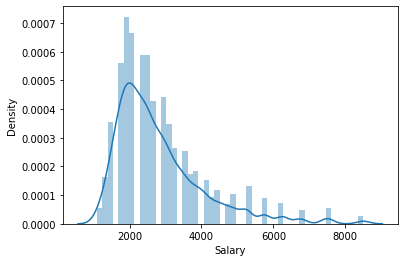

In [6]:
sns.distplot(y_train); plt.show() 

#### 수치형/범주형 피처 분리 & 학습/평가 데이터 분할

In [7]:
numeric_features = ['대학성적']
categorical_features = ['직종','세부직종','직무태그','근무경력','근무형태','근무지역','출신대학','대학전공','어학시험','자격증']

X_train = X_train[numeric_features+categorical_features]  # 순서 주의!!!
X_test = X_test[numeric_features+categorical_features]

####  파이프라인 구축
- 단계1) LGBM에서 튜닝한 값으로 전처리 파라미터 설정 (전처리 파이프라인으로만 구성)

In [8]:
def remove_outlier(X, q=0.05):  
    df = pd.DataFrame(X)
    return df.apply(lambda x: x.clip(x.quantile(q), x.quantile(1-q)), axis=0).values

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("outlier", FunctionTransformer(remove_outlier, kw_args={'q':0.05})), # 함수를 전처리기로 변환하여 sklearn에 없는 새로운 전처리기를 만듬
        ("scaler", PowerTransformer()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")), 
        ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999, dtype=np.object)),
    ]
)

column_transformer = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocessor = Pipeline(
    steps=[
        ("column", column_transformer), 
        ("selector", SelectPercentile(percentile=100)),
#        ("dataframe", FunctionTransformer(lambda x: pd.DataFrame(x, columns=numeric_features+categorical_features))),
    ]
)

set_config(display="diagram")  # To view the text pipeline, change to display='text'.
preprocessor

Pipeline(steps=[('column',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('outlier',
                                                                   FunctionTransformer(func=<function remove_outlier at 0x7f58f12df040>,
                                                                                       kw_args={'q': 0.05})),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  ['대학성적']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(dtype=<class 'object'>,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=99999))]),
                                                  ['직종', '세부직종', '직무태그', '근무경력',
                                                   '근무형태', '근무지역', '출신대학',
                                                   '대학전공', '어학시험', '자격증'])])),
                ('selector', SelectPercentile(percentile=100))])

- 단계2) 전처리 파이프라인 실행 & Output을 데이터프레임으로 변환

In [9]:
preprocessor.fit(X_train, y_train)
mask = preprocessor.steps[-1][-1].get_support()
new_features = X_train.columns[mask]
#피처 셀렉션된 피처를 새로운 피처로 지정

X_train = pd.DataFrame(preprocessor.transform(X_train), columns=new_features)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=new_features)

numeric_features = list(set(numeric_features) & set(new_features))
categorical_features = list(set(categorical_features) & set(new_features))

#### CatBoost 모형 생성
- No tuning, early_stopping 사용 (tuning한 모델에 비해 성능이 떨어지지 않음)

In [10]:
scores = []  # CV 결과 저장
oof_pred = np.zeros(X_test.shape[0])  # OOF 저장
kfold = KFold(n_splits=5, shuffle=True, random_state=0) # K-Folds cross-validator

for train_index, valid_index in kfold.split(X_train, y_train): 
    # 학습/검증 데이터 분할
    train_x, valid_x = X_train.iloc[train_index], X_train.iloc[valid_index]
    train_y, valid_y = y_train.iloc[train_index], y_train.iloc[valid_index]

    # 범주형피처 직접 처리와 Early stopping을 사용하여 CatBoost 모델링
    model = CatBoostRegressor(cat_features=categorical_features, verbose=False, random_state=0)
    model.fit(train_x, train_y,
              eval_set=[(valid_x,valid_y)],
              early_stopping_rounds=100,
             )

    # CV 스코어 계산 및 저장
    rmse = np.sqrt(mean_squared_error(valid_y, model.predict(valid_x)))
    scores.append(rmse)

    # OOF 예측값 저장
    oof_pred += model.predict(X_test) / kfold.get_n_splits() 

In [11]:
scores = np.array(scores) 
print("CV scores: ", scores)
print("CV mean = %.2f" % scores.mean(), "with std = %.2f" % scores.std())

CV scores:  [883.65649032 867.53189167 900.43806899 843.0257103  856.94896156]
CV mean = 870.32 with std = 20.08


In [12]:
# submission 화일 생성
filename = f'catboost_{CATBOOST_VERSION}_{scores.mean():.2f}.csv'
pd.DataFrame({'ID':test_id, 'Salary':oof_pred}).to_csv(filename, index=False)

<font color="#CC3D3D"><p>
# End